# Attention Monitoring with PyTorch

Performed image and video classification with a Convolutional Neural Network in Python using PyTorch.
- Fine-tuned the top layers of a [ResNeXt-101-32x8d](https://pytorch.org/hub/pytorch_vision_resnext/) model pre-trained with the [ImageNet](https://image-net.org/) dataset.
- Used model to classify video clips and live video feed.

**UPDATE IMAGE!**
<img align="left" src="../notebook_pics/structure.png">

<p><a name="sections"></a></p>

## Sections
- <a href="#Data">Data</a><br>
- <a href="#Data Pre-processing">Data Pre-processing</a><br>
- <a href="#Transfer Learning">Transfer Learning: Fine Tuning</a><br>
    - <a href="#Load and Modify">Load and Modify</a><br>
    - <a href="#Training">Training</a><br>
    - <a href="#Re-training">Re-training</a><br>
- <a href="#Glimpse">A Glimpse into the CNN</a><br>
- <a href="#Video Classification">Video Classification</a><br>
- <a href="#Results">Results</a><br>

<p><a name="Data"></a></p>

## Data
I compiled, prepared, labeled and split the images myself. 
- 10427 images in total.
    - Attentive: 5318 
    - Not Attentive: 5109 
- Roughly a 70-15-15 split among the training, validating, and testing sets.
    - Train: 7302
    - Validate: 1561
    - Test: 1564
    

In [1]:
# Construct the path
DATA_PATH = "./data"
TRAIN_PATH = f'{DATA_PATH}/train/'
VALID_PATH = f'{DATA_PATH}/valid/'
TEST_PATH = f'{DATA_PATH}/test/'

<p><a name="Data Pre-processing"></a></p>

## Data Pre-processing
- Renamed and coverted all images to .jpg format using the application IrFan View.
- The steps for getting it into the network via the `ImageDataGenerator` class are roughly:
    - Read the picture files.
    - Decode the .jpg content to RBG grids of pixels.
    - Transform the images (resize, augment, convert into floating point tensors which rescales the pixel values (between 0 and 255) to the [0, 1] interval as neural networks prefer to deal with small input values and augment the data.
    
[Data augmentation](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) is done to create more diversity among the data set so the model is more generalizable. 

I chose to resize the images to 224x224 simply for consistency since most ImageNet CNNs are trained on 224x224 resolution images. However, it is not necessary as CNNs can accept [any input size](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160147).

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms as T

image_width = 224
image_height = 224
image_size = (image_width, image_height)

# 32 images will be processed at a time
batch_size = 32 

# Initialize training, validation, and testing generators
data_transforms = {
    'train':
        T.Compose([
            T.Resize(image_size),
            T.CenterCrop(size=220),
            T.RandomAdjustSharpness(sharpness_factor=2),
            T.RandomAutocontrast(),
            T.RandomPosterize(bits=4),
            T.ToTensor() # image is scaled to [0.0, 1.0],
            ]),
    'val':
        T.Compose([
            T.Resize(image_size),
            T.ToTensor()
            ]),
    'test':
        T.Compose([
            T.Resize(image_size),
            T.ToTensor()
            ])
}

image_datasets = {
    'train':
        datasets.ImageFolder(TRAIN_PATH, data_transforms['train']),
    'val':
        datasets.ImageFolder(VALID_PATH, data_transforms['val']),
    'test':
        datasets.ImageFolder(TEST_PATH, data_transforms['test'])
}

dataloaders = {
    'train':
        DataLoader(
            image_datasets['train'],
            batch_size=batch_size,
            shuffle=True),
    'val':
        DataLoader(
            image_datasets['val'],
            batch_size=batch_size,
            shuffle=False),
    'test':
        DataLoader(
            image_datasets['test'],
            batch_size=batch_size,
            shuffle=False)
}

# The dictionary 'dataset_sizes' will be used during training 
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

### Visualize Augmented Images
We can gain an idea of how the training images will look: 

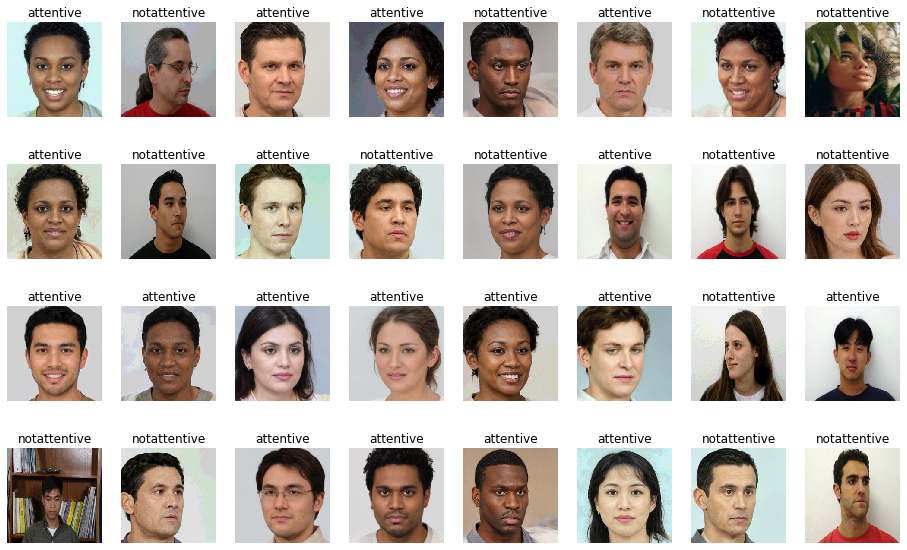

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Get a batch of training data
inputs, labels = next(iter(dataloaders['train']))

plt.figure(figsize=(16, 10))
for i, (img, label) in enumerate(zip(inputs, labels)):
    plt.subplot(4, 8, i+1)
    plt.title(class_names[label])
    plt.axis('off')
    plt.imshow(np.transpose(img.numpy(),(1,2,0)), interpolation="nearest")

**Note**: Torchvision could be utilized to preview the data augmentations, but one wouldn't be able to label each indvidual image if the images canvas multiple rows, since the labeling is limited to the plots' title.

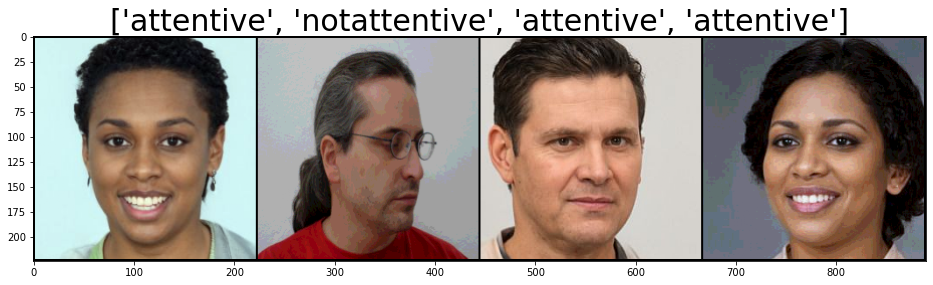

In [4]:
import torchvision 

def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.imshow(np.transpose(inp.numpy(),(1,2,0)))
    if title is not None:
        plt.title(title, fontsize=30)
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure(figsize=(16, 10))
out = torchvision.utils.make_grid(inputs[0:4])              
imshow(out, title=[class_names[x] for x in labels[0:4]])

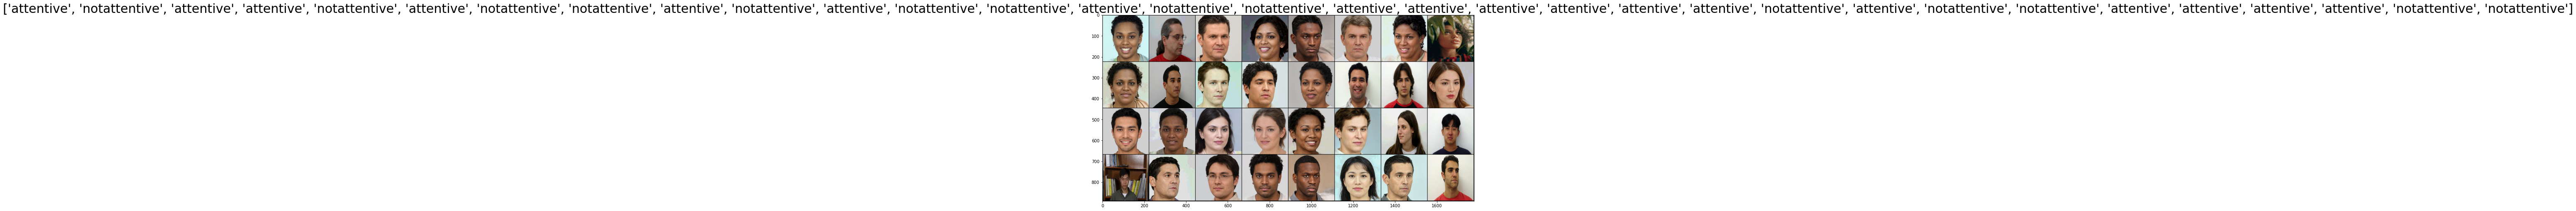

In [5]:
out = torchvision.utils.make_grid(inputs)      
plt.figure(figsize=(16, 10))
imshow(out, title=[class_names[x] for x in labels])

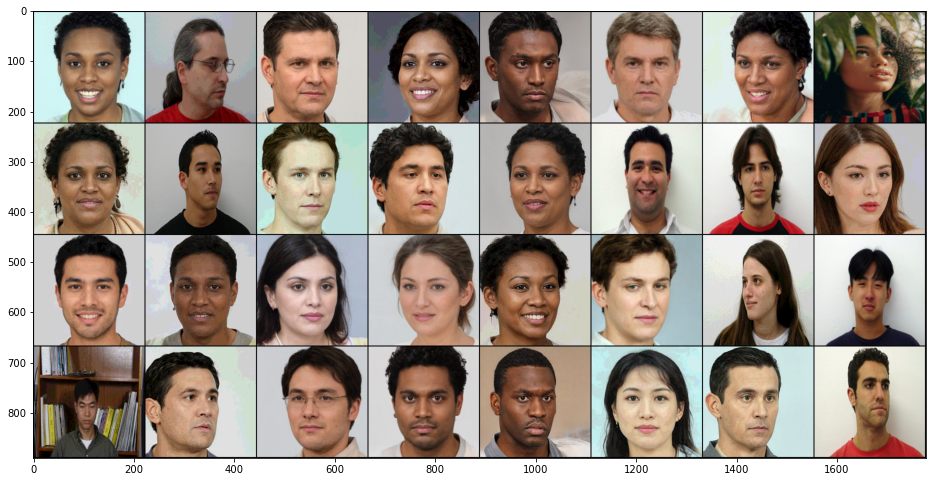

In [6]:
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(16, 10))
imshow(out)

<p><a name="Transfer Learning"></a></p>

## Transfer Learning: Fine-Tuning

<p><a name="Load and Modify"></a></p>

### Load and Modify Model
Using a CNN pre-trained on a very large dataset, such as ImageNet, would yield much better results than training the CNN myself on a much more limited dataset. 

"In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest" (*https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor*).

ResNeXt-101-32x8d was chosen due to better performance compared to other [architectures](https://pytorch.org/vision/stable/models.html). Instead of increasing the depth or width, ResNeXt focuses on increasing cardinality to improve classification accuracy. Cardinality is the size of the set of transformations. 

The ResNeXt model was "pre-trained in weakly-supervised fashion on 940 million public images with 1.5K hashtags matching with 1000 ImageNet1K synsets, followed by fine-tuning on ImageNet1K dataset" (*https://pytorch.org/hub/facebookresearch_WSL-Images_resnext/#model-description*).

Paper: https://arxiv.org/abs/1611.05431

Models: https://pytorch.org/vision/stable/models.html#resnext

In [7]:
import torch
from torchvision.models import resnext101_32x8d as Resnext101

# Use CPU vs GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Resnext101_32x8d model without the top fully-connected layers 
# since I will construct my own.
model = Resnext101(pretrained=True, progress = True)

In [8]:
for i, param in enumerate(model.named_parameters(), 1):
    print(f"{i}: {param[0]} {param[1].size()}")
    print(param[1].requires_grad,end='\n\n')

1: conv1.weight torch.Size([64, 3, 7, 7])
True

2: bn1.weight torch.Size([64])
True

3: bn1.bias torch.Size([64])
True

4: layer1.0.conv1.weight torch.Size([256, 64, 1, 1])
True

5: layer1.0.bn1.weight torch.Size([256])
True

6: layer1.0.bn1.bias torch.Size([256])
True

7: layer1.0.conv2.weight torch.Size([256, 8, 3, 3])
True

8: layer1.0.bn2.weight torch.Size([256])
True

9: layer1.0.bn2.bias torch.Size([256])
True

10: layer1.0.conv3.weight torch.Size([256, 256, 1, 1])
True

11: layer1.0.bn3.weight torch.Size([256])
True

12: layer1.0.bn3.bias torch.Size([256])
True

13: layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
True

14: layer1.0.downsample.1.weight torch.Size([256])
True

15: layer1.0.downsample.1.bias torch.Size([256])
True

16: layer1.1.conv1.weight torch.Size([256, 256, 1, 1])
True

17: layer1.1.bn1.weight torch.Size([256])
True

18: layer1.1.bn1.bias torch.Size([256])
True

19: layer1.1.conv2.weight torch.Size([256, 8, 3, 3])
True

20: layer1.1.bn2.weight torch.S

In [9]:
from torchsummary import summary
summary(model, (3, 224, 224))

C:\Users\Tyrone\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]          16,384
       BatchNorm2d-6          [-1, 256, 56, 56]             512
              ReLU-7          [-1, 256, 56, 56]               0
            Conv2d-8          [-1, 256, 56, 56]          18,432
       BatchNorm2d-9          [-1, 256, 56, 56]             512
             ReLU-10          [-1, 256, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          65,536
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

- Other views into the model

In [10]:
# print(model)

In [11]:
# for i, param in enumerate(model.named_modules(), 1):
#     print(f"{i}: {param[0], {param[1]}}\n\n")

- Ultimately, only the fully connected layers will be trained.

In [12]:
# Exclude subgraphs from gradient computation

# UNCOMMENT TO TRAIN THE LAST CONVOLUTIONAL BLOCK ALONG WITH THE HEAD
# for param in model.named_parameters():
#     param[1].requires_grad = True if 'layer4' in param[0] else False 

for param in model.named_parameters():
    param[1].requires_grad = False 

In [13]:
for i, param in enumerate(model.named_parameters(), 1):
    print(f"{i}: {param[0]} {param[1].size()}")
    print(param[1].requires_grad,end='\n\n')

1: conv1.weight torch.Size([64, 3, 7, 7])
False

2: bn1.weight torch.Size([64])
False

3: bn1.bias torch.Size([64])
False

4: layer1.0.conv1.weight torch.Size([256, 64, 1, 1])
False

5: layer1.0.bn1.weight torch.Size([256])
False

6: layer1.0.bn1.bias torch.Size([256])
False

7: layer1.0.conv2.weight torch.Size([256, 8, 3, 3])
False

8: layer1.0.bn2.weight torch.Size([256])
False

9: layer1.0.bn2.bias torch.Size([256])
False

10: layer1.0.conv3.weight torch.Size([256, 256, 1, 1])
False

11: layer1.0.bn3.weight torch.Size([256])
False

12: layer1.0.bn3.bias torch.Size([256])
False

13: layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
False

14: layer1.0.downsample.1.weight torch.Size([256])
False

15: layer1.0.downsample.1.bias torch.Size([256])
False

16: layer1.1.conv1.weight torch.Size([256, 256, 1, 1])
False

17: layer1.1.bn1.weight torch.Size([256])
False

18: layer1.1.bn1.bias torch.Size([256])
False

19: layer1.1.conv2.weight torch.Size([256, 8, 3, 3])
False

20: layer1.1

- The new head of the ResNeXt network

In [14]:
# # Create basic fully connected layers
# import torch.nn as nn
# num_ftrs = model.fc.in_features
# # Here the size of each output sample is set to 1 since we are dealing 
# # with binary classification.
# model.fc = nn.Linear(num_ftrs, 1)
# model = model.to(device)

In [15]:
# Create more complex fully connected layers
# Explains last layer: https://stackoverflow.com/a/60169820
import torch.nn as nn
model.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 1),
            nn.Sigmoid())
model = model.to(device)

In [16]:
for i, param in enumerate(model.named_parameters(), 1):
    print(f"{i}: {param[0]}, \n{param[1].size()}")
    print(param[1].requires_grad,end='\n\n')

1: conv1.weight, 
torch.Size([64, 3, 7, 7])
False

2: bn1.weight, 
torch.Size([64])
False

3: bn1.bias, 
torch.Size([64])
False

4: layer1.0.conv1.weight, 
torch.Size([256, 64, 1, 1])
False

5: layer1.0.bn1.weight, 
torch.Size([256])
False

6: layer1.0.bn1.bias, 
torch.Size([256])
False

7: layer1.0.conv2.weight, 
torch.Size([256, 8, 3, 3])
False

8: layer1.0.bn2.weight, 
torch.Size([256])
False

9: layer1.0.bn2.bias, 
torch.Size([256])
False

10: layer1.0.conv3.weight, 
torch.Size([256, 256, 1, 1])
False

11: layer1.0.bn3.weight, 
torch.Size([256])
False

12: layer1.0.bn3.bias, 
torch.Size([256])
False

13: layer1.0.downsample.0.weight, 
torch.Size([256, 64, 1, 1])
False

14: layer1.0.downsample.1.weight, 
torch.Size([256])
False

15: layer1.0.downsample.1.bias, 
torch.Size([256])
False

16: layer1.1.conv1.weight, 
torch.Size([256, 256, 1, 1])
False

17: layer1.1.bn1.weight, 
torch.Size([256])
False

18: layer1.1.bn1.bias, 
torch.Size([256])
False

19: layer1.1.conv2.weight, 
torch.Si

307: layer4.2.conv2.weight, 
torch.Size([2048, 64, 3, 3])
False

308: layer4.2.bn2.weight, 
torch.Size([2048])
False

309: layer4.2.bn2.bias, 
torch.Size([2048])
False

310: layer4.2.conv3.weight, 
torch.Size([2048, 2048, 1, 1])
False

311: layer4.2.bn3.weight, 
torch.Size([2048])
False

312: layer4.2.bn3.bias, 
torch.Size([2048])
False

313: fc.1.weight, 
torch.Size([1024, 2048])
True

314: fc.1.bias, 
torch.Size([1024])
True

315: fc.4.weight, 
torch.Size([1, 1024])
True

316: fc.4.bias, 
torch.Size([1])
True



In [17]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]          16,384
       BatchNorm2d-6          [-1, 256, 56, 56]             512
              ReLU-7          [-1, 256, 56, 56]               0
            Conv2d-8          [-1, 256, 56, 56]          18,432
       BatchNorm2d-9          [-1, 256, 56, 56]             512
             ReLU-10          [-1, 256, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          65,536
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

- Other views into the model

In [18]:
# print(model)

In [19]:
# for i, param in enumerate(model.named_modules(), 1):
#     print(f"{i}: {param[0], {param[1]}}\n\n")

### Training and Validation
I tweaked the generic training function provided in PyTorch's documentation [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model).

In [20]:
import time
import copy
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()
    
    history = {'train_acc':[], 'train_loss':[], 'val_acc':[], 'val_loss':[]}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch, data in enumerate(dataloaders[phase],1):
                inputs, labels = data
                inputs = inputs.to(device)
                # So labels can match shape and data format of model output
                labels = labels.view(-1,1).to(torch.float32).to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + Optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if batch % 50 == 0:
                    print('Batch #{} - {} Loss: {:.4f} Acc: {:.4f}\n'.format(
                        batch, phase, 
                        running_loss / dataset_sizes[phase], 
                        running_corrects.double() / dataset_sizes[phase]))
                else:
                    print(f"Batch #{batch}")
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print()
            print(f"Final batch #{batch}")
            print('Final {} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            print()
            
            # Track training accuracy and loss
            if phase == 'train':
                history['train_acc'].append(epoch_acc)
                history['train_loss'].append(epoch_loss)
            
            # Tracking validation accuracy and loss
            if phase == 'val':
                history['val_acc'].append(epoch_acc)
                history['val_loss'].append(epoch_loss)
                
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

- Set up loss function and optimizer

In [22]:
from torch import optim
criterion = nn.BCELoss()

# Remember, only selected parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Decay lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 2

- Train and validate the model

In [23]:
model1, history = train_model(model, criterion, optimizer, 
                                          exp_lr_scheduler, num_epochs=num_epochs)

Epoch 1/2
----------
Batch #1
Batch #2
Batch #3
Batch #4
Batch #5
Batch #6
Batch #7
Batch #8
Batch #9
Batch #10
Batch #11
Batch #12
Batch #13
Batch #14
Batch #15
Batch #16
Batch #17
Batch #18
Batch #19
Batch #20
Batch #21
Batch #22
Batch #23
Batch #24
Batch #25
Batch #26
Batch #27
Batch #28
Batch #29
Batch #30
Batch #31
Batch #32
Batch #33
Batch #34
Batch #35
Batch #36
Batch #37
Batch #38
Batch #39
Batch #40
Batch #41
Batch #42
Batch #43
Batch #44
Batch #45
Batch #46
Batch #47
Batch #48
Batch #49
Batch #50
Batch #51
Batch #52
Batch #53
Batch #54
Batch #55
Batch #56
Batch #57
Batch #58
Batch #59
Batch #60
Batch #61
Batch #62
Batch #63
Batch #64
Batch #65
Batch #66
Batch #67
Batch #68
Batch #69
Batch #70
Batch #71
Batch #72
Batch #73
Batch #74
Batch #75
Batch #76
Batch #77
Batch #78
Batch #79
Batch #80
Batch #81
Batch #82
Batch #83
Batch #84
Batch #85
Batch #86
Batch #87
Batch #88
Batch #89
Batch #90
Batch #91
Batch #92
Batch #93
Batch #94
Batch #95
Batch #96
Batch #97
Batch #98
Batch #9

- Save the model

In [24]:
torch.save(model1.state_dict(), './resnext101/model1/weights.h5')

- Load the model

In [25]:
model1_1 = Resnext101(pretrained=True)
model1_1.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 1),
            nn.Sigmoid())
model1_1.load_state_dict(torch.load('./resnext101/model1/weights.h5'))
model1_1 = model1_1.to(device)

- The loss and accuracy of the model over the training and validation data during training are plotted, and the plots are saved:

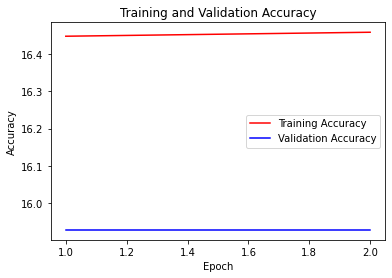

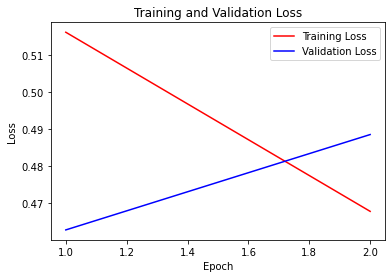

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

train_acc = history['train_acc']
train_loss = history['train_loss']
val_acc = history['val_acc']
val_loss = history['val_loss']

epochs = range(1,num_epochs+1)

plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('./resnext101/model1/graphs/Accuracy1.jpg')
plt.figure()

plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('./resnext101/model1/graphs/Loss1.jpg')

plt.show()

### Evaluate Model
I used the generic visualization/evaluation function provided in PyTorch's documentation [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#visualizing-the-model-predictions) with minimal tweaks.

In [27]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                fig = plt.figure(figsize=(16, 10))
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]), fontsize=20)
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

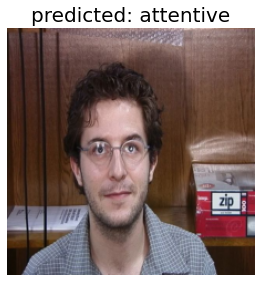

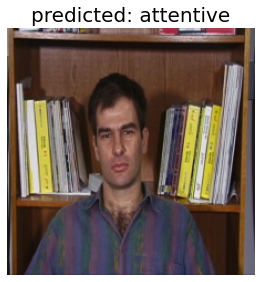

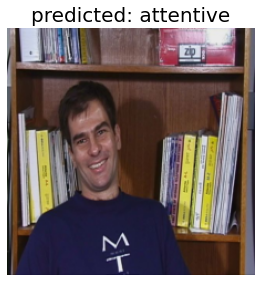

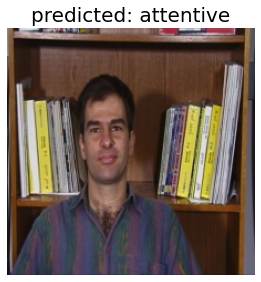

In [28]:
visualize_model(model1_1, 4)

<p><a name="Glimpse"></a></p>

## A Glimpse into the CNN
~ Let's see what the CNN sees ~

_Note: For this section, I modified code which can be found [here](https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/). Sovit did a SUPERB job breaking everything down._



In [29]:
print(model1_1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [30]:
conv_layers = [] # we will save the conv layers in this list
model_weights = [] # we will save the conv layer weights in this list

In [31]:
# get all the model children as list
model_children = list(model1_1.children())

- Retrieve all the convolutional layers and their weights.

In [32]:
def layers_and_weights(children, layers, weights):
    """
    Append all the conv layers and their respective weights to lists.
    
    Convolutional layers at 2 levels of nesting:
    1) The "top" layers; the direct children of the model.
    2) The Bottleneck layers inside the sequential blocks.
       More on Bottleneck layers: (https://ai.stackexchange.com/a/4887).
    
    If any of the above two conditions satisfy, that child node and its
    weights are appended to layers and weights respectively.
    
    """
    
    for i in range(len(children)):
        if type(children[i]) == nn.Conv2d:
            weights.append(children[i].weight)
            layers.append(children[i])
        elif type(model_children[i]) == nn.Sequential:
            for j in range(len(children[i])):
                for child in children[i][j].children():
                    if type(child) == nn.Conv2d:
                        weights.append(child.weight)
                        layers.append(child)
    return children, layers, weights

In [33]:
model_children,conv_layers,model_weights = layers_and_weights(model_children,conv_layers,model_weights)

In [34]:
print(f"Total convolutional layers: {len(conv_layers)}")

Total convolutional layers: 100


In [35]:
# You can take a look at the conv layers and their respective weights
for weight, conv in zip(model_weights, conv_layers):
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")
#     print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print()

CONV: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) ====> SHAPE: torch.Size([64, 3, 7, 7])

CONV: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 64, 1, 1])

CONV: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False) ====> SHAPE: torch.Size([256, 8, 3, 3])

CONV: Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 256, 1, 1])

CONV: Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 256, 1, 1])

CONV: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False) ====> SHAPE: torch.Size([256, 8, 3, 3])

CONV: Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 256, 1, 1])

CONV: Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 256, 1, 1])

CONV: Conv2d(256, 256, kernel_size=(3,

### Visualizing the Convolutional Layer Filters
Filters = weights, and they determine the parts of the image the model will focus on.

Only the filters of the first convolutional layer are visualized below, but you can look at others.

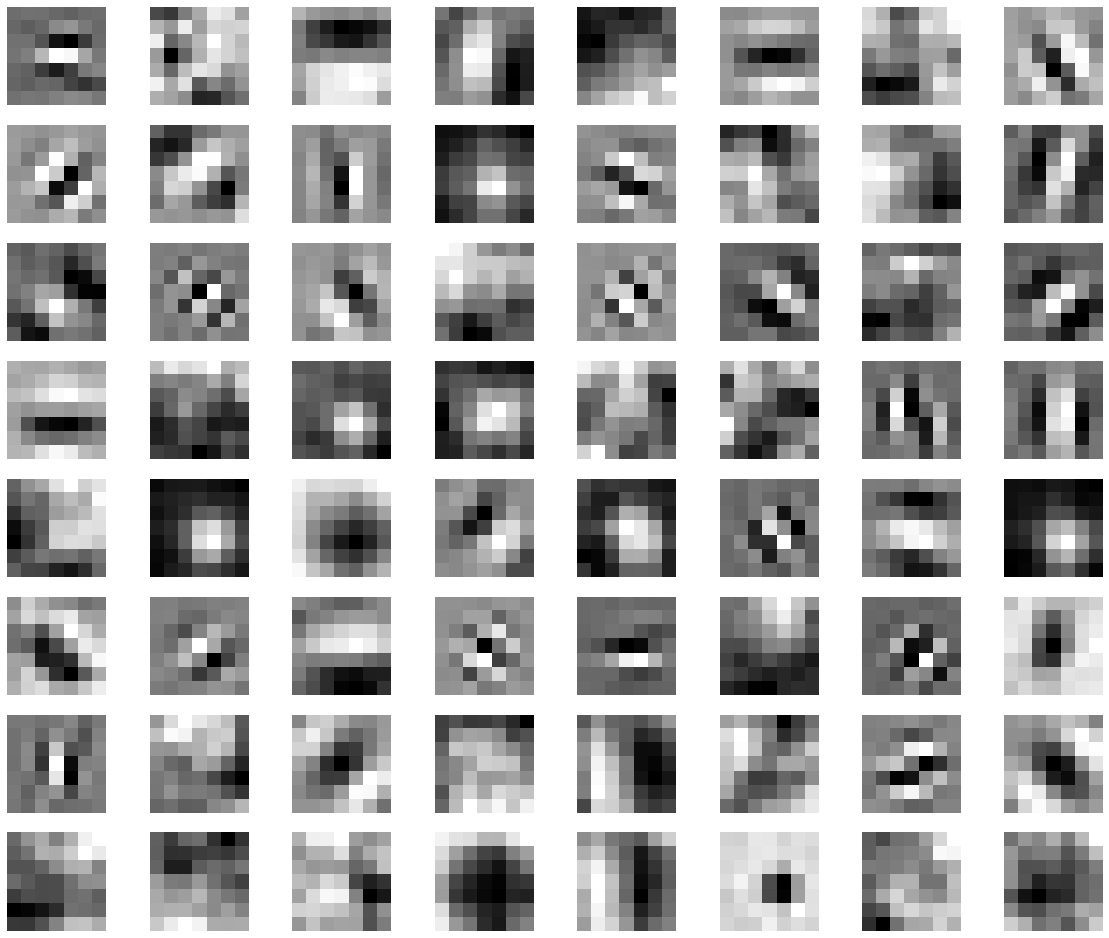

In [64]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, fliter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) since in conv0 we have 64 7x7 filters
    plt.imshow(fliter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('./resnext101/model1/filters/conv1_filter_gray.jpg')
plt.show()

ValueError: 'rgb' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

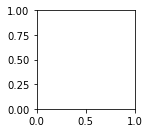

In [69]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, fliter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) since in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(fliter[0, :, :].detach(), cmap='rgb')
    plt.axis('off')
plt.show()

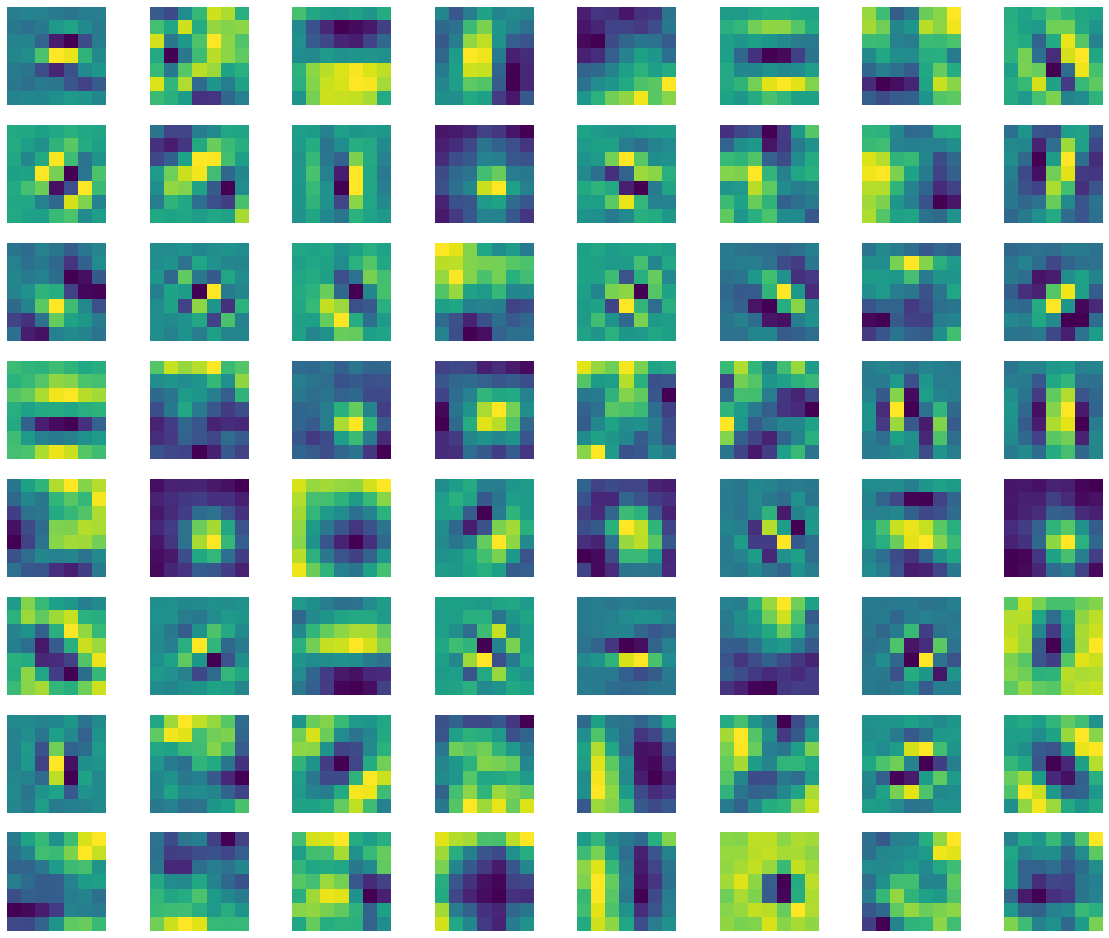

In [65]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, fliter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) since in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(fliter[0, :, :].detach())
    plt.axis('off')
    plt.savefig('./resnext101/model1/filters/conv1_filter_color.jpg')
plt.show()

**Note:**
- The image is on a yellow --> green colorscale because that's how 
- The model will focus more on the areas of the image where the weight values are more, the brighter patches, when doing the element-wise product of the weights with the pixel values.

### Visualizing the Convolutional Layer Feature Maps
Feature maps are what the convolutional layer *sees* after the image passes through a filter.

I will be using the following image in the visualizations:

In [44]:
inputs, labels = next(iter(dataloaders['test']))

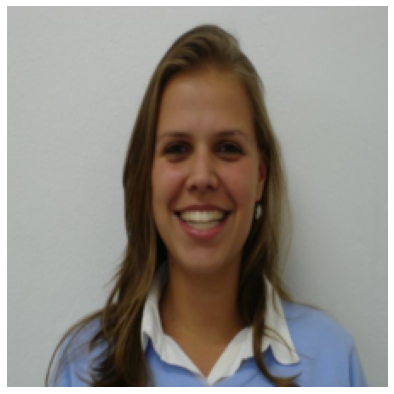

In [45]:
plt.figure(figsize=(10, 7))
plt.axis('off')
imshow(inputs[11])

In [50]:
inputs[11].size()

torch.Size([3, 224, 224])

In [55]:
# Adding that 1st dimension indicates a batch size of 1
img = inputs[11].view(1,3,224,224) 

In [56]:
img.size()

torch.Size([1, 3, 224, 224])

- Pass image through each convolutional layer

In [57]:
# pass the image through all the layers
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the output or result of the previous layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

- Visualize the feature maps

In [72]:
# Since the upper layers have many feature maps, the visualizations will
# be capped at 64 for each layer.

for num_layer in range(0, len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(f"Layer {num_layer+1} size: {layer_viz.size()}")
    for i, fliter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(fliter, cmap='gray')
        plt.axis("off")
    print(f"Saving feature maps...")
    plt.savefig(f"./resnext101/model1/featuremaps/gray/layer{num_layer}.jpg")
    print()
    # plt.show()
    plt.close()
print('All done!')

Layer 1 size: torch.Size([64, 112, 112])
Saving feature maps...

Layer 2 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 3 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 4 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 5 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 6 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 7 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 8 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 9 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 10 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 11 size: torch.Size([512, 112, 112])
Saving feature maps...

Layer 12 size: torch.Size([512, 56, 56])
Saving feature maps...

Layer 13 size: torch.Size([512, 56, 56])
Saving feature maps...

Layer 14 size: torch.Size([512, 56, 56])
Saving feature maps...

Layer 15 size: torch.Size([512, 56, 56])
Saving feature maps...

Layer 16 size

In [73]:
# Since the upper layers have many feature maps, the visualizations will
# be capped at 64 for each layer.

for num_layer in range(0, len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(f"Layer {num_layer+1} size: {layer_viz.size()}")
    for i, fliter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(fliter)
        plt.axis("off")
    print(f"Saving feature maps...")
    plt.savefig(f"./resnext101/model1/featuremaps/color/layer{num_layer}.jpg")
    print()
    # plt.show()
    plt.close()
print('All done!')

Layer 1 size: torch.Size([64, 112, 112])
Saving feature maps...

Layer 2 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 3 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 4 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 5 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 6 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 7 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 8 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 9 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 10 size: torch.Size([256, 112, 112])
Saving feature maps...

Layer 11 size: torch.Size([512, 112, 112])
Saving feature maps...

Layer 12 size: torch.Size([512, 56, 56])
Saving feature maps...

Layer 13 size: torch.Size([512, 56, 56])
Saving feature maps...

Layer 14 size: torch.Size([512, 56, 56])
Saving feature maps...

Layer 15 size: torch.Size([512, 56, 56])
Saving feature maps...

Layer 16 size

<p><a name="Video Classification"></a></p>

## Video Classification

In [70]:
import cv2 as cv
import numpy as np

VIDEO_NAME = "Example3.mp4"
VIDEO_IN = "videos/in/"
VIDEO_OUT = "videos/out/"

frame_width, frame_height = None, None

classes = ['ATTENTIVE', 'NOT ATTENTIVE']

In [71]:
# Capturing videoclip or livestream
# capturing = VIDEO_IN+VIDEO_NAME # videoclip
capturing = 0 # livestream; webcam

cap = cv.VideoCapture(capturing)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
    
writer = None
fps = 5 # frames saved to video

In [ ]:
model_1.eval()
# Loop over frames from the video stream
while True:    
    # Capture frame-by-frame
    is_present, frame = cap.read()

    # If is_present is false, frame was read incorrectly or we have 
    # reached the end of the video
    if not is_present:
        print("Can't receive frame (stream end?). Exiting ...")
        break
        
    # Get frame dimensions if empty
#     if frame_width is None or frame_height is None:
#         frame_width, frame_height = frame.shape[:2]
        
    # Operations on the frame: Convert, Resize, Rescale
    output = frame.copy()
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    frame = cv.resize(frame, (224, 224)).astype("float32")
    frame /= 255
    
    #################################
    with torch.no_grad():
        frame = data_transforms['test'](frame)
        pred = model1_1(frame).cpu().numpy()[0][0]
    
    
    
    # Label the current frame
    percent_pred = model4.predict(np.expand_dims(frame, axis=0))[0]
    percent_pred = float(*percent_pred)*100
    preds = 0 if percent_pred < 99 else 1

    label = classes[preds]    

    # Write the label on the output frame
#     text = f"{label}: {percent_pred}%"
    text = f"{label}"
    org = (35, 50)
    font = cv.FONT_HERSHEY_DUPLEX
    fontScale = 1.25
    color = (0, 255, 0)
    thickness = 3
    cv.putText(output, text, org, font, fontScale, color, thickness)
    
    # Check if videowriter is None
    if writer is None:
        # Define the codec and create VideoWriter object
        fourcc = cv.VideoWriter_fourcc(*"MP4V")
        writer = cv.VideoWriter(VIDEO_OUT+VIDEO_NAME, fourcc, fps,
            (int(cap.get(3)),int(cap.get(4))), True)
        
    # Write output frame to disk
    writer.write(output)
    
    # Show output images
    cv.imshow("Output", output)
    
    # Break loop when 'q' is pressed
    if cv.waitKey(1) & 0xFF == ord("q"):
        break
        
# Release the file pointers
cap.release()
writer.release()

# Close all windows
cv.destroyAllWindows()